In [1]:
from music21 import converter, instrument, note, chord, stream, corpus, environment
import glob
import numpy
import tensorflow as ts
import random
from tensorflow import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import *
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

# If GPU is an option
if len(ts.config.experimental.list_physical_devices('GPU')) > 0:
    print(ts.config.list_physical_devices('GPU'))
    print("Num GPUs Available: ", len(ts.config.experimental.list_physical_devices('GPU')))
    gpus = ts.config.experimental.list_physical_devices('GPU')
    ts.config.experimental.set_memory_growth(gpus[0], True)
    sess = ts.compat.v1.Session()


C:\Users\hugofac.TECGRAF\Anaconda3\envs\ts-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\hugofac.TECGRAF\Anaconda3\envs\ts-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\hugofac.TECGRAF\Anaconda3\envs\ts-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\hugofac.TECGRAF\Anaconda3\envs\

In [2]:
numpy.random.seed()

def getNotes(folderPath):
    notes = []
    print("Starting to read files...")
    for file in glob.glob(folderPath + "/*.mid"):
        print(file)
        midi = converter.parse(file)
        print("file parsed")
        notes_to_parse = None
        parts = instrument.partitionByInstrument(midi)
        if parts: # file has instrument parts
            notes_to_parse = parts.parts[0].recurse()
        else: # file has notes in a flat structure
            notes_to_parse = midi.flat.notes
        for element in notes_to_parse:
            if isinstance(element, note.Note):
                notes.append(str(element.pitch))
            elif isinstance(element, chord.Chord):
                notes.append('.'.join(str(n) for n in element.normalOrder))
    print("Files read")
    return notes

In [3]:
# sequence_length is how many notes will be passed at once as an input
def prepareSequences(notes, sequence_length):
    print("Generating the dictionary and converting the notes to integers...")

    n_vocab = len(set(notes))
    
    # get all pitch names
    pitchnames = sorted(set(item for item in notes))

     # create a dictionary to map pitches to integers
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    network_input = []
    network_output = []

    # create input sequences and the corresponding outputs
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])
        network_output.append(note_to_int[sequence_out])

    n_patterns = len(network_input)

    # reshape the input into a format compatible with LSTM layers
    network_input = numpy.reshape(network_input, (n_patterns, sequence_length, 1))
    # normalize input
    network_input = network_input / float(n_vocab)

    network_output = np_utils.to_categorical(network_output)

    return network_input, network_output, pitchnames

In [4]:
def buildLSTMModel(network_input, outputSize):
    print("Building the LSTM...")
    model = Sequential()
    model.add(LSTM(
        256,
        input_shape=(network_input.shape[1], network_input.shape[2]),
        return_sequences=True
    ))
    model.add(Dropout(0.3))
    model.add(LSTM(512, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(256))
    model.add(Dense(256))
    model.add(Dropout(0.3))
    model.add(Dense(outputSize))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop') 

    print("Built")
    return model

In [5]:
def trainModel(model, network_input, network_output, Iepochs=200, Ibatch_size = 64, callback = True):
    if callback:
        filepath = "Beth&Moz-{epoch:02d}-{loss:.4f}-bigger.hdf5"    
        checkpoint = ModelCheckpoint(
            filepath, monitor='loss', 
            verbose=0,        
            save_best_only=True,        
            mode='min'
        )    
        callbacks_list = [checkpoint] 
    else:
        callbacks_list = None

    model.fit(network_input, network_output, epochs=Iepochs, batch_size=Ibatch_size, callbacks=callbacks_list)
    return model

In [6]:
def randomPrediction(probVector):
    PV = probVector[0]
    randNum = random.uniform(0, 1)
    sumVector = 0
    for i in range(0, len(PV)):
        sumVector += PV[i]
        if sumVector > randNum:
            return i

def generateSong (model, notes, name, argmax = True):
    print("Generating song...")

    n_vocab = len(set(notes))
    
    # get all pitch names
    pitchnames = sorted(set(item for item in notes))
    
    start = numpy.random.randint(0, len(network_input)-1)
    int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
    pattern = network_input[start]
    prediction_output = []
    # generate 500 notes
    for note_index in range(500):
        prediction_input = numpy.reshape(pattern, (1, len(pattern),1))
        prediction_input = prediction_input / float(n_vocab)
        prediction = model.predict(prediction_input, verbose=0)
        if argmax:
            index = numpy.argmax(prediction)
        else:
            index = randomPrediction(prediction)
        result = int_to_note[index]
        prediction_output.append(result)
        pattern = numpy.append(pattern,index)
        pattern = pattern[1:len(pattern)]



    offset = 0
    output_notes = []
    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)
        # increase offset each iteration so that notes do not stack
        offset += 0.5

    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp= name + '.mid')

    print("Song finished")

In [7]:
notes = getNotes('midi_classic')

Starting to read files...
midi_classic\appass_1.mid
file parsed
midi_classic\appass_2.mid
file parsed
midi_classic\appass_3.mid
file parsed
midi_classic\beethoven_hammerklavier_1.mid
file parsed
midi_classic\beethoven_hammerklavier_2.mid
file parsed
midi_classic\beethoven_hammerklavier_3.mid
file parsed
midi_classic\beethoven_hammerklavier_4.mid
file parsed
midi_classic\beethoven_les_adieux_1.mid
file parsed
midi_classic\beethoven_les_adieux_2.mid
file parsed
midi_classic\beethoven_les_adieux_3.mid
file parsed
midi_classic\beethoven_opus10_1.mid
file parsed
midi_classic\beethoven_opus10_2.mid
file parsed
midi_classic\beethoven_opus10_3.mid
file parsed
midi_classic\beethoven_opus22_1.mid
file parsed
midi_classic\beethoven_opus22_2.mid
file parsed
midi_classic\beethoven_opus22_3.mid
file parsed
midi_classic\beethoven_opus22_4.mid
file parsed
midi_classic\beethoven_opus90_1.mid
file parsed
midi_classic\beethoven_opus90_2.mid
file parsed
midi_classic\elise.mid
file parsed
midi_classic\mond

In [8]:
network_input, network_output, pitchnames = prepareSequences(notes, 100)

Generating the dictionary and converting the notes to integers...


In [9]:
model = buildLSTMModel(network_input, len(set(notes)))

Building the LSTM...
Built


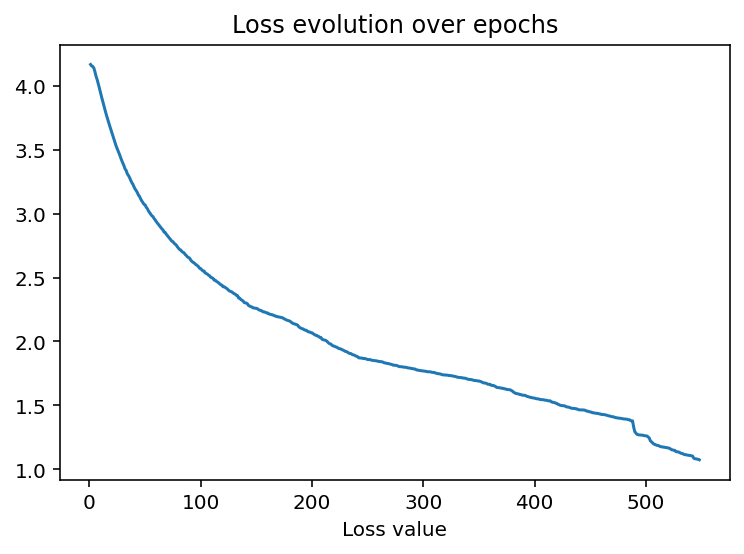

In [10]:
# model = trainModel(model, network_input, network_output, 0)
# Loss graph over all traning, only saved the loss value when it was better
weights = numpy.load('outfile.npy')

pos = []
val = []
for i in range(0,len(weights)):
    pos.append(i+1)
    val.append(weights[i])

plt.plot(pos,val)
plt.xlabel('Approximated Epoch')
plt.xlabel('Loss value')
plt.title('Loss evolution over epochs')
plt.show()

In [11]:
model.load_weights('Weights.hdf5')

In [12]:
generateSong (model, notes, 'Result_LSTM')

Generating song...

Song finished


In [13]:
print(network_input.shape[1])
print(network_input.shape[2])

100
1
